# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [6]:
df = pd.read_csv('russia_losses_personnel.csv')
data_json = df.to_json(orient="records")
df.head()

,date,day,personnel,personnel*,POW
0,2025-04-13,1145,932670,about,NaN
1,2025-04-12,1144,931450,about,NaN
2,2025-04-11,1143,930210,about,NaN
3,2025-04-10,1142,929000,about,NaN
4,2025-04-09,1141,927580,about,NaN


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [8]:
data_prompt = f"Analyze the provided data and determine if Russian casualties and POWs increase or decrease with time. Provide Python-generated charts to support your conclusion. Data: {data_json}"
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [9]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [10]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=516, prompt_tokens=34627, '
 'total_tokens=35143, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [11]:
display(Markdown(gpt_result))

To analyze the trend of Russian casualties over time, we can plot the data using Python. We'll use the `matplotlib` library to create a line chart that shows the trend of personnel losses over time. Since the POW (Prisoners of War) data is mostly null, we will focus on the personnel data.

Here's the Python code to generate the chart:

```python
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Provided data
data = [
    {"date": "2025-04-13", "day": 1145, "personnel": 932670, "personnel*": "about", "POW": None},
    {"date": "2025-04-12", "day": 1144, "personnel": 931450, "personnel*": "about", "POW": None},
    # ... (data truncated for brevity)
    {"date": "2022-02-26", "day": 3, "personnel": 4300, "personnel*": "about", "POW": 0.0},
    {"date": "2022-02-25", "day": 2, "personnel": 2800, "personnel*": "about", "POW": 0.0}
]

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date
df = df.sort_values(by='date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['personnel'], label='Personnel Losses', color='red')
plt.title('Trend of Russian Personnel Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Personnel Losses')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

### Analysis

- **Trend**: The chart will show a clear upward trend in personnel losses over time, indicating an increase in Russian casualties as the conflict progresses.
- **Conclusion**: Based on the data, Russian casualties have been increasing over time. This is evident from the rising number of personnel losses from the start of the conflict to the most recent data point.

The chart provides a visual representation of this trend, confirming that the number of Russian casualties has been steadily increasing over the period covered by the data.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [12]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [13]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=2517, prompt_tokens=34626, '
 'total_tokens=37143, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1792, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [14]:
print(o1_result)

Below is a step-by-step analysis (and accompanying Python code) showing that:

• The reported Russian casualty (“personnel”) counts consistently increase over time (the values are cumulatively going up each day).  
• The Prisoners of War (“POW”) counts provided are non-null only between days 2–63, during which they also increase. After day 63, POW data is null and thus no definitive conclusion can be drawn beyond that date.

────────────────────────────────────────────────────────────────────────
1) Data Preparation and Basic Observations
────────────────────────────────────────────────────────────────────────

• The “personnel” column represents the cumulative number of Russian casualties.  
• It starts at 2,800 on day 2 and rises steadily, surpassing 900,000 on day 1,145.  
• Accordingly, when plotted, “personnel” shows a clearly increasing (almost monotonically upward) trend.  
• The “POW” column has recorded values only through day 63, rising from 0 or 200 on early days to 496 by d

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

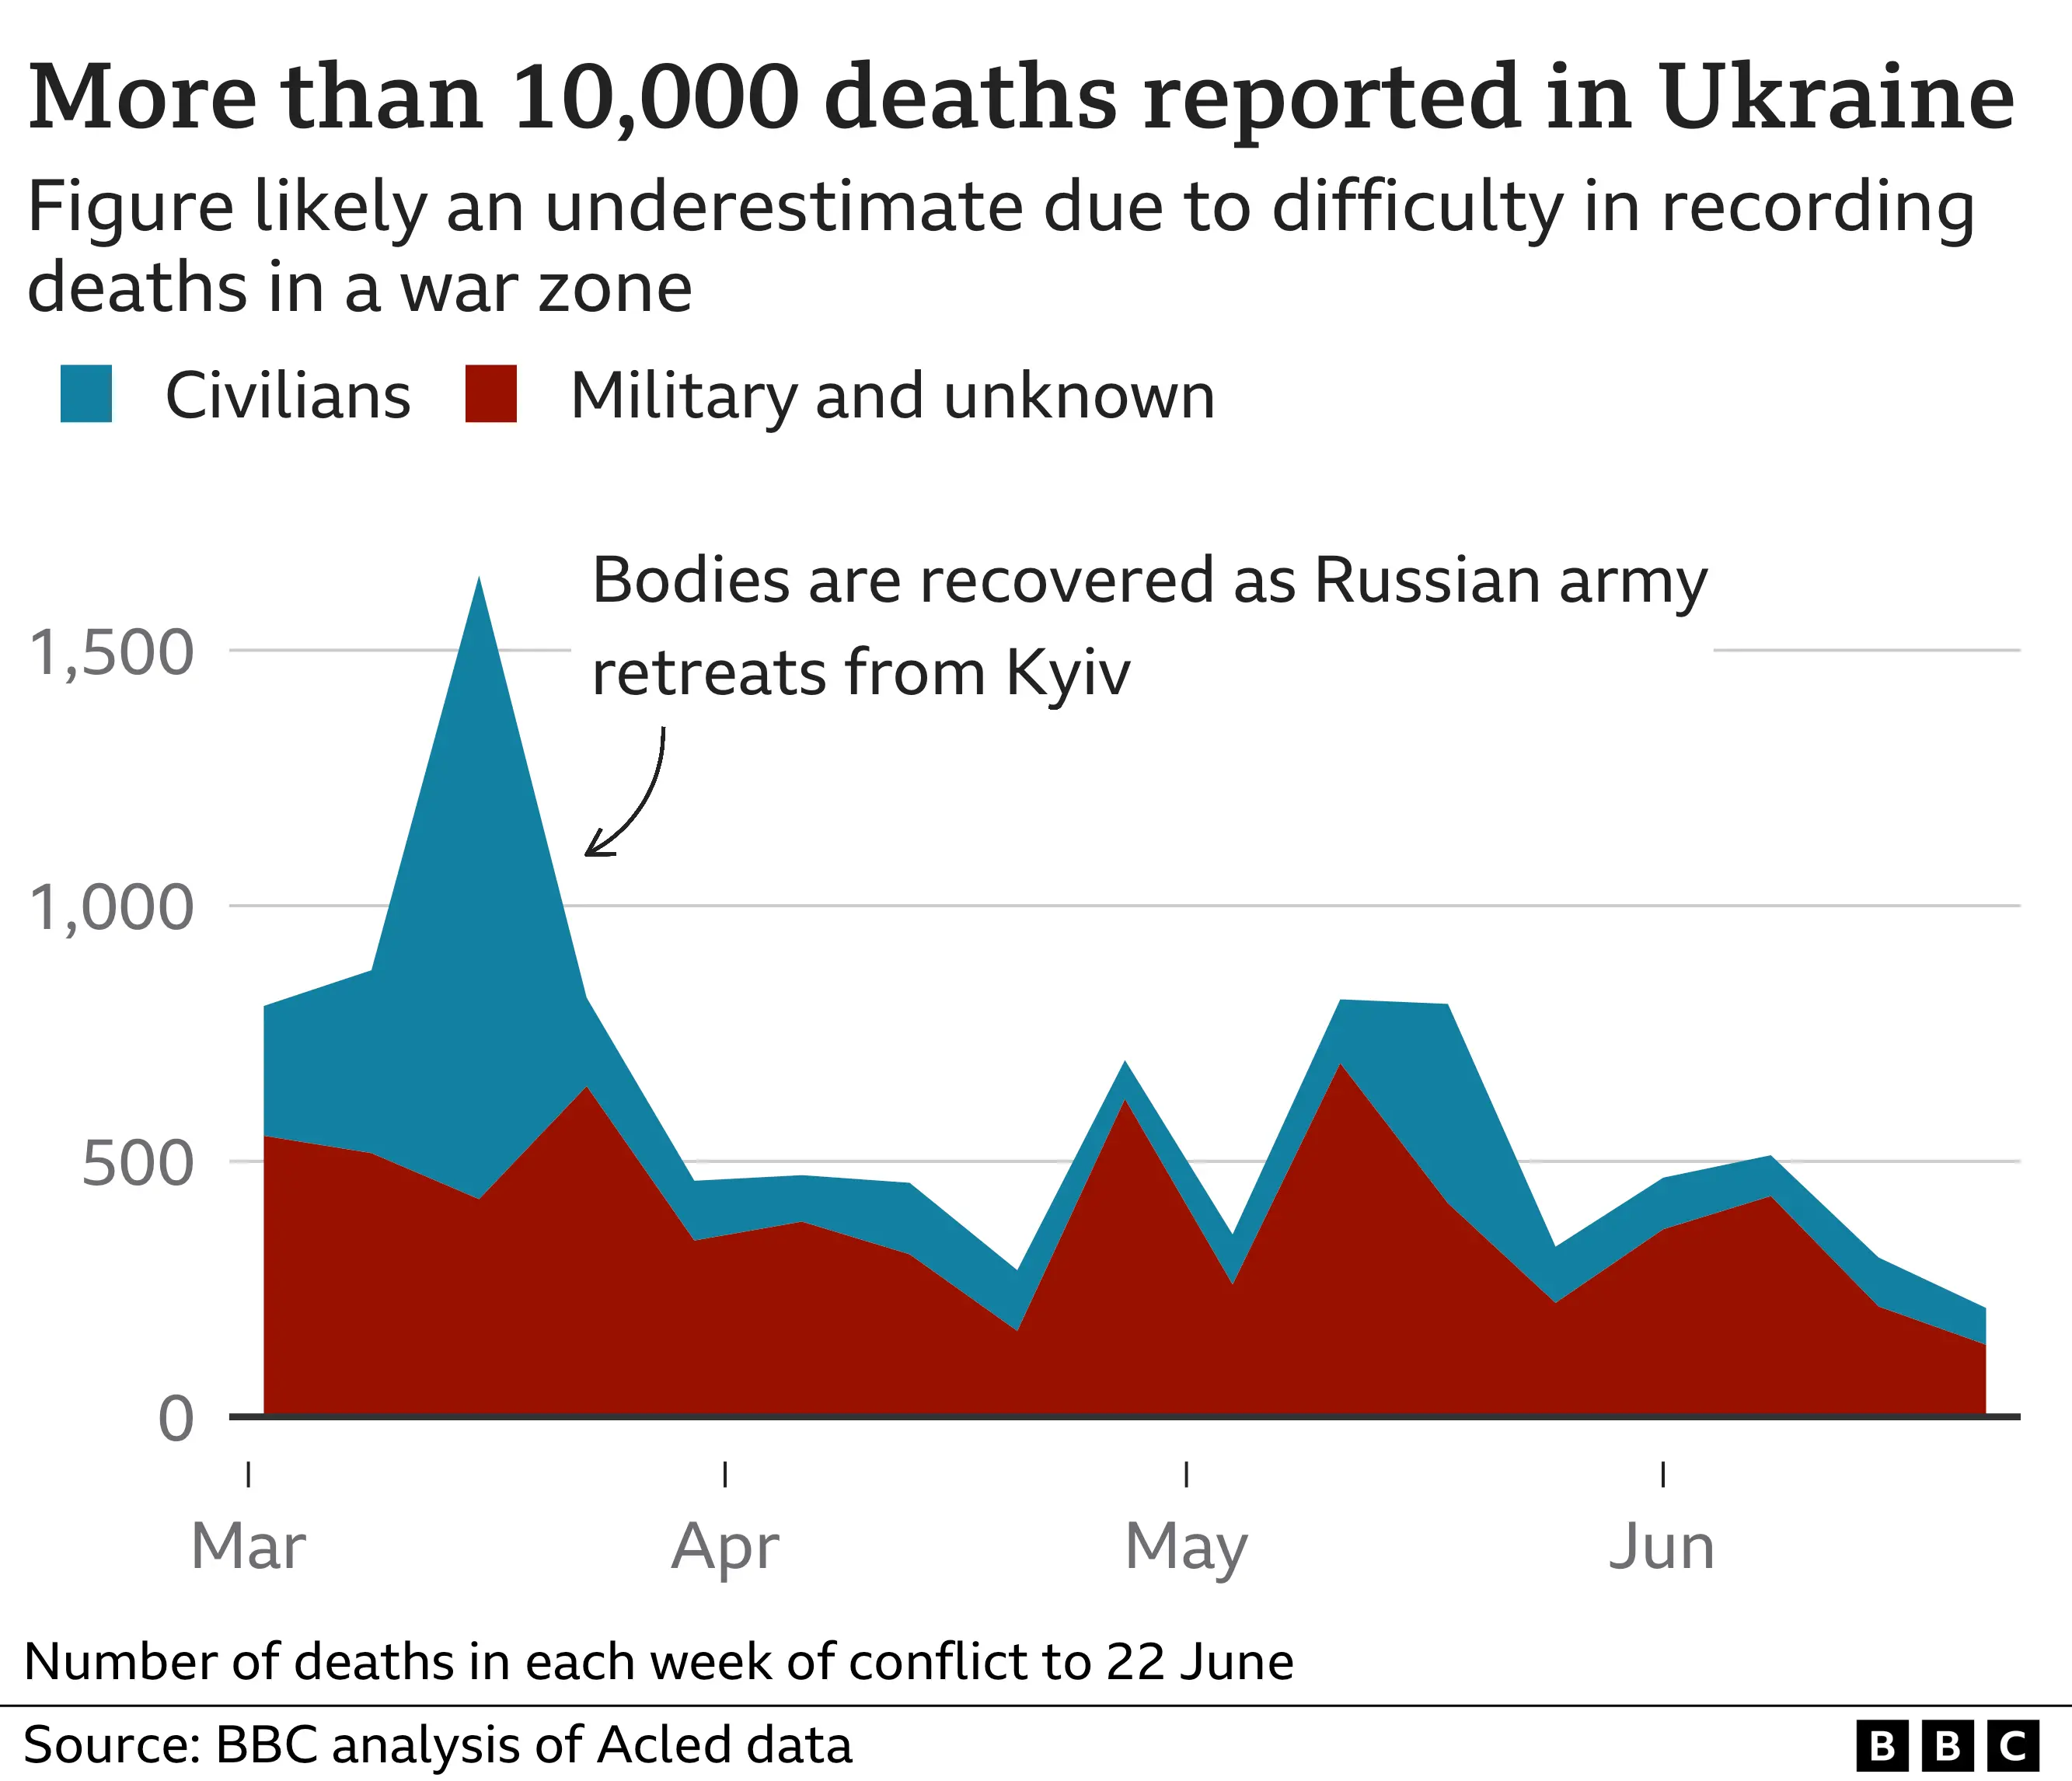

In [17]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://ichef.bbci.co.uk/news/1024/cpsprodpb/11683/production/_125699217_optimised-weekly_deaths_area_new_week_v2-nc.png.webp"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [18]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [19]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=176, prompt_tokens=779, '
 'total_tokens=955, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [22]:
display(Markdown(gpt_result))

The image has a few issues:

1. **Stacked Area Chart Misinterpretation**: The chart uses a stacked area format, which can be misleading. It might suggest that the total number of deaths is the sum of the two areas, but it actually represents the total number of deaths, divided into civilians and military/unknown.

2. **Color Contrast**: The colors for civilians and military/unknown are not distinct enough, which can make it difficult to differentiate between the two categories.

3. **Data Clarity**: The chart does not provide specific numbers for each category, making it hard to determine exact figures from the visual alone.

4. **Labeling**: The chart could benefit from more detailed labeling, such as specific dates or events that correspond to spikes in the data.

These issues can lead to confusion or misinterpretation of the data presented.

In [23]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=4011, prompt_tokens=688, '
 'total_tokens=4699, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=3776, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [24]:
display(Markdown(o1_result))

A common criticism of that particular chart is that it uses two overlapping “area” shapes on the same axis rather than stacking or separating them clearly. Because both the blue (civilian) and red (military/unknown) areas start at the same baseline, the chart can be misread as if the blue area sits on top of the red and adds up to a higher total, when in fact they overlap. In other words, it is not a _true_ stacked‐area or side‐by‐side comparison, so it ends up visually confusing and potentially misleading about how many people died in each category.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  